In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Import statements required for Plotly 
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls


from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
from imblearn.over_sampling import SMOTE
import xgboost

/home/tapas/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



In [2]:
import os
os.chdir('/home/tapas/HR_Analytics/')

In [3]:
df = pd.read_csv('HR_data.csv')
df.head(5)

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


In [4]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
df["Attrition_numerical"] = df["Attrition"].apply(lambda x: target_map[x])

In [5]:
# creating a list of only numerical values
numerical = [u'Age', u'DailyRate', u'DistanceFromHome', u'Education', u'EmployeeNumber', u'EnvironmentSatisfaction',
       u'HourlyRate', u'JobInvolvement', u'JobLevel', u'JobSatisfaction',
       u'MonthlyIncome', u'MonthlyRate', u'NumCompaniesWorked',
       u'PercentSalaryHike', u'PerformanceRating', u'RelationshipSatisfaction',
       u'StockOptionLevel', u'TotalWorkingYears',
       u'TrainingTimesLastYear', u'WorkLifeBalance', u'YearsAtCompany',
       u'YearsInCurrentRole', u'YearsSinceLastPromotion',
       u'YearsWithCurrManager']

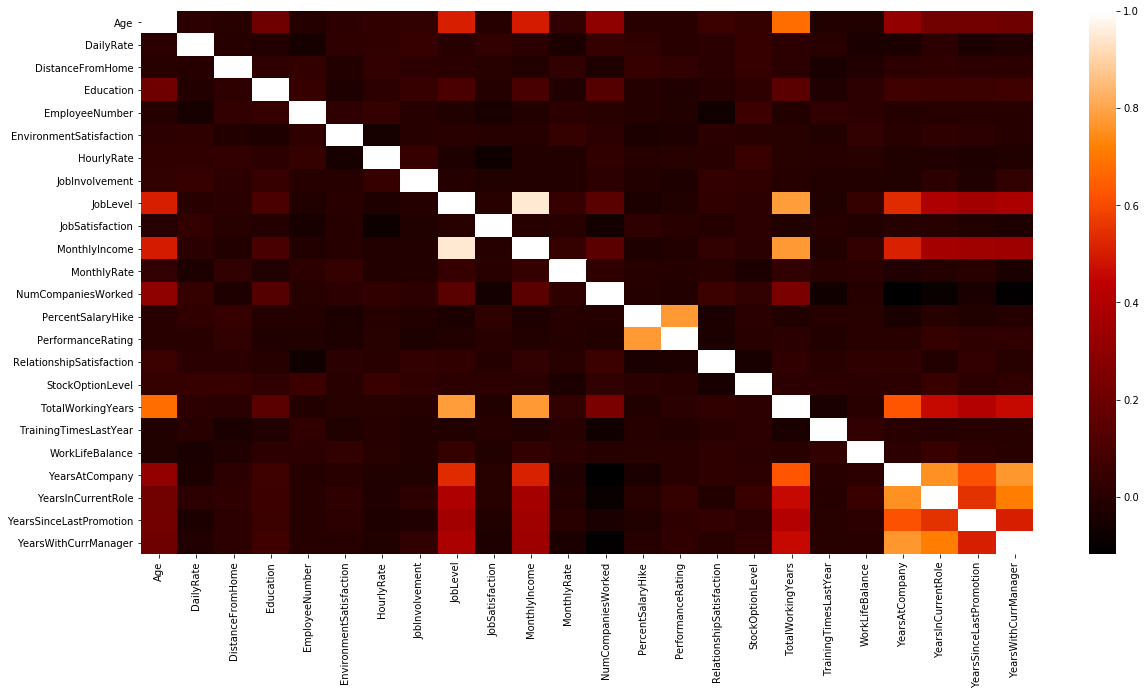

In [6]:
# Heatmap showing the correlation of various columns with each other.

ax = plt.figure(figsize = (20,10))
ax = sns.heatmap(df[numerical].corr(),cmap = 'gist_heat')

In [7]:
# Refining our list of numerical variables
numerical = [u'Age', u'DailyRate',  u'JobSatisfaction',
       u'MonthlyIncome', u'PerformanceRating',
        u'WorkLifeBalance', u'YearsAtCompany', u'Attrition_numerical']

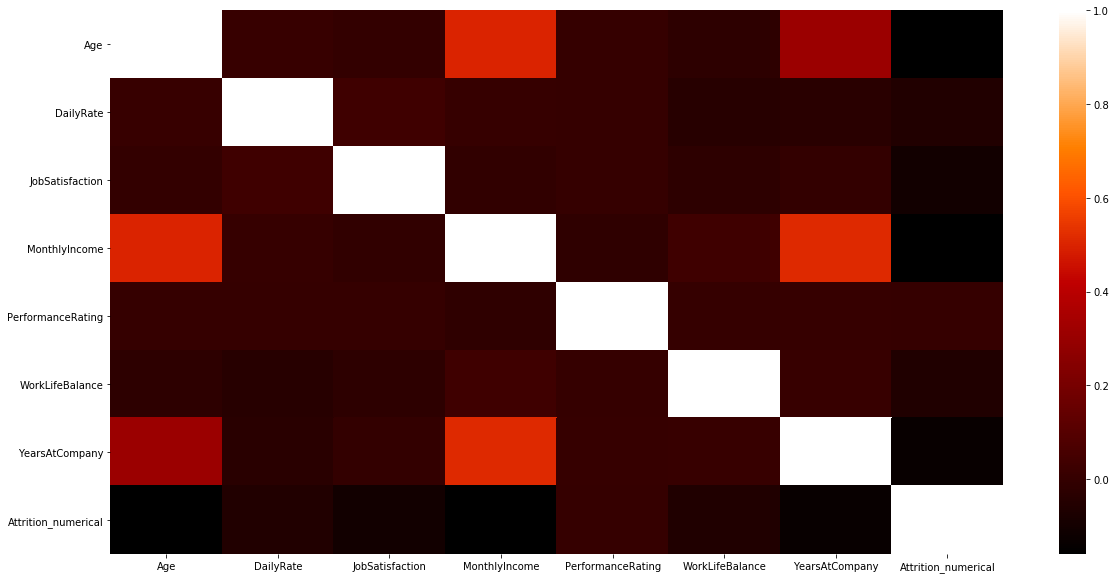

In [8]:
# Heatmap showing the correlation of various columns with each other.

ax = plt.figure(figsize = (20,10))
ax = sns.heatmap(df[numerical].corr(),cmap = 'gist_heat')

/home/tapas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning:

The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.



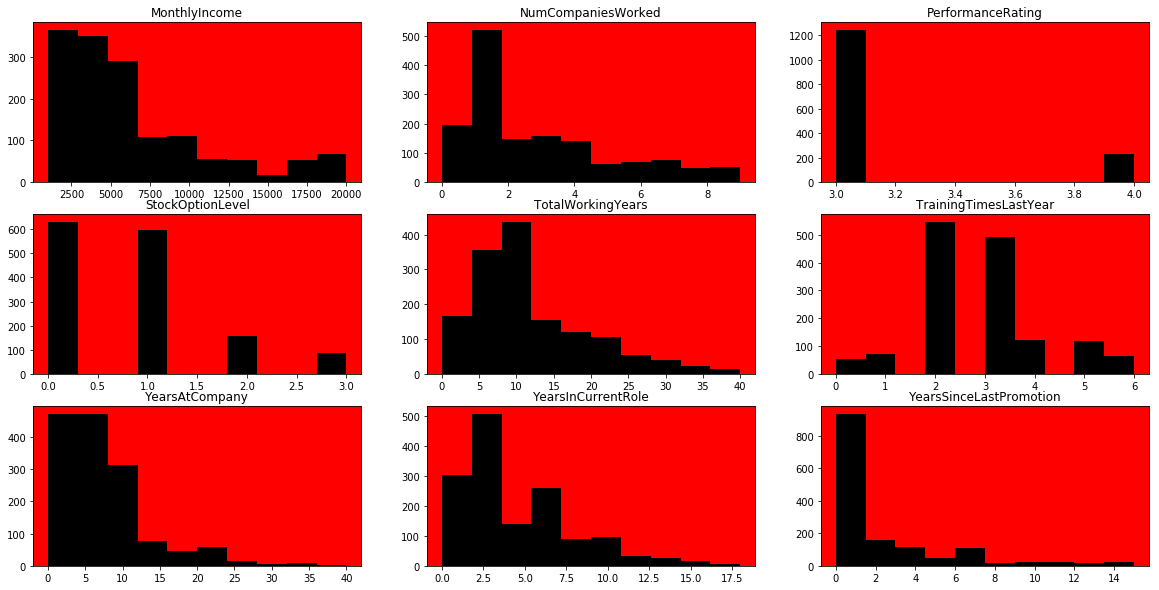

In [9]:
# The features with skewed or non-normal distribution.
skew_df = df[['MonthlyIncome','NumCompaniesWorked','PerformanceRating','StockOptionLevel','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany','YearsInCurrentRole','YearsSinceLastPromotion']]
fig , ax = plt.subplots(3,3,figsize = (20,10))
col = skew_df.columns
for i in range(3):
    for j in range(3):
        ax[i][j].hist(skew_df[col[3 * i + j]] , color = 'k')
        ax[i][j].set_title(str(col[3 * i + j]))
        ax[i][j].set_axis_bgcolor((1, 0, 0))

In [10]:
df_t = df.select_dtypes(exclude=['object'])

In [11]:
# Dividing the data into quantiles and doing the outlier analysis.

Q1 = df_t.quantile(0.25)
Q3 = df_t.quantile(0.75)
IQR = Q3 - Q1

((df_t < (Q1 - 1.5 * IQR)) | (df_t > (Q3 + 1.5 * IQR))).sum()

Age                           0
DailyRate                     0
DistanceFromHome              0
Education                     0
EmployeeCount                 0
EmployeeNumber                0
EnvironmentSatisfaction       0
HourlyRate                    0
JobInvolvement                0
JobLevel                      0
JobSatisfaction               0
MonthlyIncome               114
MonthlyRate                   0
NumCompaniesWorked           52
PercentSalaryHike             0
PerformanceRating           226
RelationshipSatisfaction      0
StandardHours                 0
StockOptionLevel             85
TotalWorkingYears            63
TrainingTimesLastYear       238
WorkLifeBalance               0
YearsAtCompany              104
YearsInCurrentRole           21
YearsSinceLastPromotion     107
YearsWithCurrManager         14
Attrition_numerical         237
dtype: int64

### Feature Engineering & Categorical Encoding

In [12]:
# Drop the Attrition_numerical column from attrition dataset first - Don't want to include that
df = df.drop(['Attrition_numerical'], axis=1)

# Empty list to store columns with categorical data
categorical = []
for col, value in df.iteritems():
    if value.dtype == 'object':
        categorical.append(col)

# Store the numerical columns in a list numerical
numerical = df.columns.difference(categorical)

In [13]:
# Store the categorical data in a dataframe called attrition_cat
df_cat = df[categorical]
df_cat = df_cat.drop(['Attrition'], axis=1) # Dropping the target column

In [14]:
df_cat = pd.get_dummies(df_cat)
df_cat.head(3)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Over18_Y,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,1,0,0,0,1,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,1,0,0,0,1,0,1,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,1


In [15]:
# Store the numerical features to a dataframe attrition_num
df_num = df[numerical]

In [16]:
# Concat the two dataframes together columnwise
df_final = pd.concat([df_num, df_cat], axis=1)

In [17]:
# Define a dictionary for the target mapping
target_map = {'Yes':1, 'No':0}
# Use the pandas apply method to numerically encode our attrition target variable
target = df["Attrition"].apply(lambda x: target_map[x])
target.head(3)

0    1
1    0
2    1
Name: Attrition, dtype: int64

# Modelling

In [18]:
# General Packages
import pandas as pd
import numpy as np
import random as rnd
import os
import re
# import multiprocessing

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (16, 8)
import scikitplot as skplt

# Supervised Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import feature_selection
import xgboost as xgb
from xgboost.sklearn import XGBClassifier # <3

# Unsupervised Models
from sklearn.decomposition import PCA

# Evalaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Grid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# Esemble Voting
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

# Stacking
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib.colors import ListedColormap

# Warnings
import warnings
warnings.filterwarnings('ignore')

import time
import datetime
import platform
start = time.time()

In [19]:
# Master Parameters:
n_splits = 5 # Cross Validation Splits
n_iter = 65 # Randomized Search Iterations
scoring = 'accuracy' # Model Selection during Cross-Validation
rstate = 25 # Random State used 
testset_size = 0.30

# Trees Parameters
n_tree_range = st.randint(600, 1200)

# XGboost boosting rounds
num_rounds = 1000

In [20]:
# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(df_final, target, test_size=testset_size, stratify=target,random_state=rstate)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Stratified Cross-Validation
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=rstate)

In [21]:
oversampler=SMOTE(random_state=0)
X_train, y_train = oversampler.fit_sample(X_train,y_train)

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [23]:
# Helper Function to visualize feature importance
predictors = [x for x in df_final.columns if x not in ['Attrition']]
def feature_imp(model):
    MO = model.fit(X_train, y_train)
    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

### Decision Tree

In [33]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

Mean CV Accuracy: 0.7673469387755103


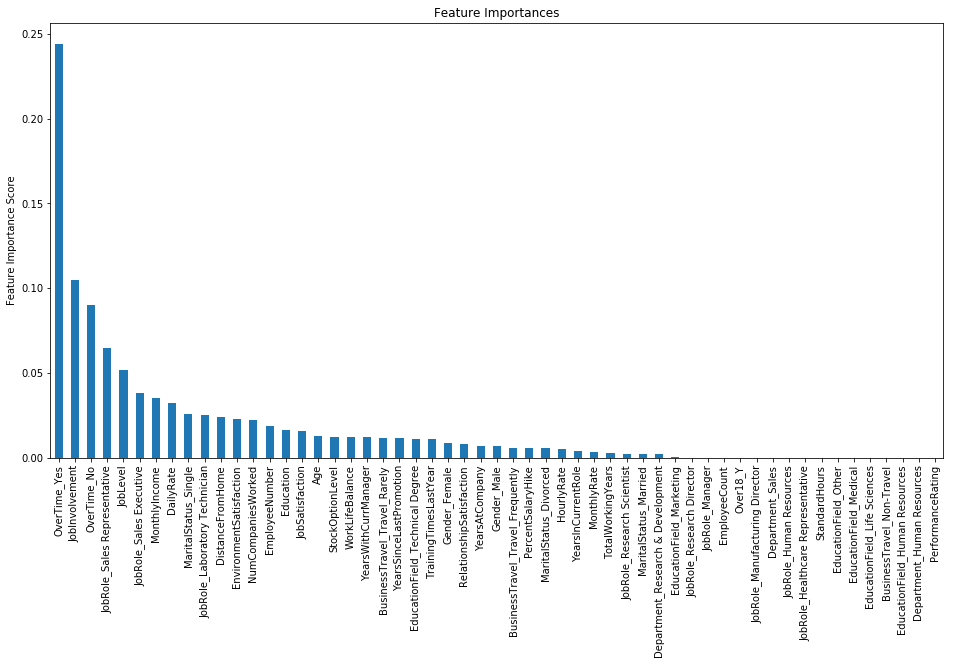

In [34]:
# Baseline Decision Tree
tree = DecisionTreeClassifier()
print("Mean CV Accuracy:",cross_val_score(tree, df_final, target, cv=cv, scoring=scoring).mean())
feature_imp(tree)

### Random Forest

Mean CV Accuracy: 0.8551020408163265


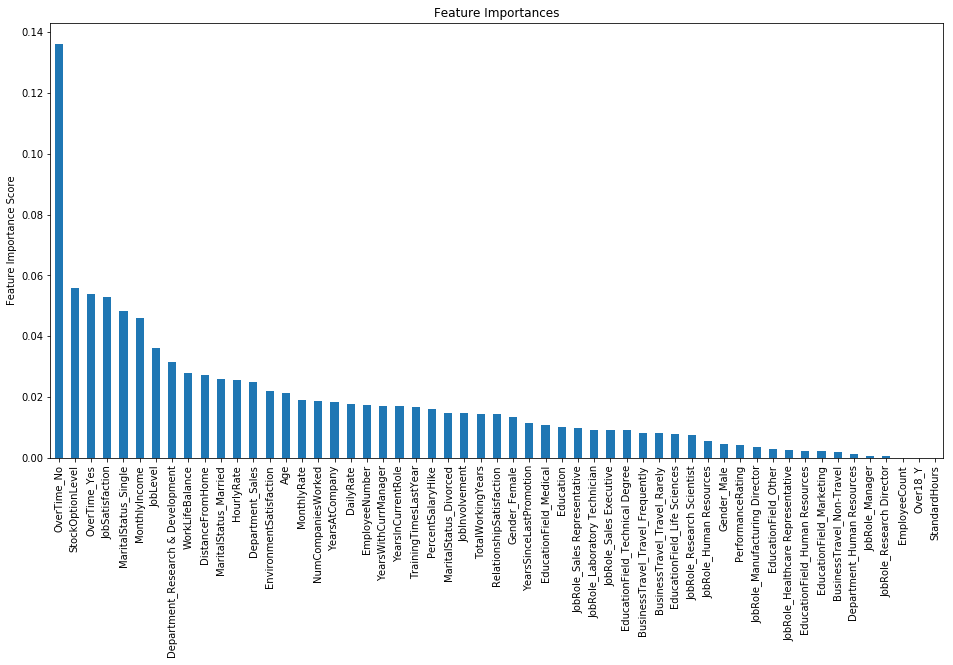

In [35]:
model = RandomForestClassifier()
print("Mean CV Accuracy:",cross_val_score(model, df_final, target, cv=cv, scoring=scoring).mean())
feature_imp(model)